In [1]:
import findspark
findspark.init()

In [2]:
from pyspark import SparkContext
from pyspark.sql import SQLContext, Row

sc = SparkContext(appName = "First Spark App")

spark = SQLContext.getOrCreate(sc).sparkSession

##### take data and create new rdd object of type - collection of lines OR in our case we created a sql dataframe which is an abstraction of rdd (Wrapping of RDD with a dataframe object)

In [3]:
df = spark.read.format("csv")\
.option("delimiter"," ")\
.load("data/kmeans_data.txt",header=False,inferSchema=True)

##### Infer Schema you're are AWESOME!!! (used above) - It correctly identifies the datatype and then cast it too

In [4]:
#let's count number of rows and view first few lines
rowNum = df.count()   
print("Total Rows:%s \n"%(rowNum))

print("Schema: ")
df.printSchema()

print("\nFirst Few Rows - \n", df.take(3))

Total Rows:96 

Schema: 
root
 |-- _c0: double (nullable = true)
 |-- _c1: double (nullable = true)
 |-- _c2: double (nullable = true)


First Few Rows - 
 [Row(_c0=0.1, _c1=0.1, _c2=0.1), Row(_c0=0.2, _c1=0.2, _c2=0.2), Row(_c0=9.0, _c1=9.0, _c2=9.0)]


In [5]:
df.describe().show()

+-------+-----------------+------------------+------------------+
|summary|              _c0|               _c1|               _c2|
+-------+-----------------+------------------+------------------+
|  count|               96|                96|                96|
|   mean|5.931249999999998|5.8791666666666655| 5.890624999999999|
| stddev|  2.6757905865665|2.7532532591049326|2.7871916869853064|
|    min|              0.1|               0.1|               0.1|
|    max|              9.9|               9.9|               9.9|
+-------+-----------------+------------------+------------------+



##### Spark ML requires your input features to be gathered in a SINGLE COLUMN OF DATAFRAME, usually named features; and it provides a specific method for doing this, VectorAssembler. 

In [6]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols = ["_c0","_c1","_c2"],outputCol = "features")  #assembler is the object of VectorAssembler
# .transform transforms the dataset into single column named features
data = assembler.transform(df)
data.show()

+---+---+---+-------------+
|_c0|_c1|_c2|     features|
+---+---+---+-------------+
|0.1|0.1|0.1|[0.1,0.1,0.1]|
|0.2|0.2|0.2|[0.2,0.2,0.2]|
|9.0|9.0|9.0|[9.0,9.0,9.0]|
|9.1|9.1|9.1|[9.1,9.1,9.1]|
|9.2|9.2|9.2|[9.2,9.2,9.2]|
|7.5|7.8|7.7|[7.5,7.8,7.7]|
|8.1|7.7|8.0|[8.1,7.7,8.0]|
|8.4|7.4|7.5|[8.4,7.4,7.5]|
|7.8|7.4|7.5|[7.8,7.4,7.5]|
|8.1|7.8|8.1|[8.1,7.8,8.1]|
|7.7|7.1|7.7|[7.7,7.1,7.7]|
|7.4|7.4|7.6|[7.4,7.4,7.6]|
|8.0|7.8|7.5|[8.0,7.8,7.5]|
|7.6|7.6|7.9|[7.6,7.6,7.9]|
|7.5|7.7|8.1|[7.5,7.7,8.1]|
|7.5|7.3|7.7|[7.5,7.3,7.7]|
|2.2|1.7|2.5|[2.2,1.7,2.5]|
|2.1|2.0|1.6|[2.1,2.0,1.6]|
|1.8|1.8|2.0|[1.8,1.8,2.0]|
|1.9|1.7|1.6|[1.9,1.7,1.6]|
+---+---+---+-------------+
only showing top 20 rows



In [7]:
# create visualization
xaxis =  data.rdd.map(lambda x: x[0]).collect()
yaxis =  data.rdd.map(lambda x: x[1]).collect()
zaxis =  data.rdd.map(lambda x: x[2]).collect()

In [8]:
%matplotlib inline

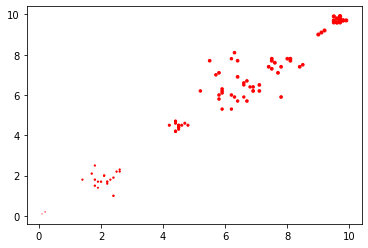

In [9]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(xaxis,yaxis,zaxis,c='r',marker='o')
plt.show()

### ELBOW method. Find Optimal Number of clusters

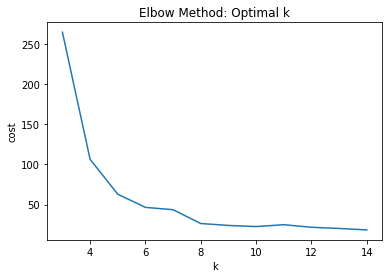

In [11]:
from pyspark.ml.clustering import KMeans

import numpy as np
cost = np.zeros(15)
for k in range(3,15):
    kmeans = KMeans().setK(k).setSeed(1)\
    .setFeaturesCol("features")\
    .setPredictionCol("cluster")
    
    model = kmeans.fit(data)
    cost[k] = model.computeCost(data)
cost

plt.title('Elbow Method: Optimal k')
plt.plot(range(3,15),cost[3:15])
plt.xlabel("k")
plt.ylabel("cost")
plt.show()

##### Optimal K = 8

In [12]:
k = 8
# apply K-means. 
kmeans = KMeans().setK(3).setSeed(1)\
.setFeaturesCol("features")\
.setPredictionCol("cluster")

model = kmeans.fit(data)
cluster = model.transform(data)

In [13]:
# Show result
result = cluster.select("features","cluster").collect()
for row in result:
    print("feature=%s, cluster=%s"
          %(row.features,row.cluster))

feature=[0.1,0.1,0.1], cluster=2
feature=[0.2,0.2,0.2], cluster=2
feature=[9.0,9.0,9.0], cluster=1
feature=[9.1,9.1,9.1], cluster=1
feature=[9.2,9.2,9.2], cluster=1
feature=[7.5,7.8,7.7], cluster=1
feature=[8.1,7.7,8.0], cluster=1
feature=[8.4,7.4,7.5], cluster=1
feature=[7.8,7.4,7.5], cluster=1
feature=[8.1,7.8,8.1], cluster=1
feature=[7.7,7.1,7.7], cluster=1
feature=[7.4,7.4,7.6], cluster=1
feature=[8.0,7.8,7.5], cluster=1
feature=[7.6,7.6,7.9], cluster=1
feature=[7.5,7.7,8.1], cluster=1
feature=[7.5,7.3,7.7], cluster=1
feature=[2.2,1.7,2.5], cluster=2
feature=[2.1,2.0,1.6], cluster=2
feature=[1.8,1.8,2.0], cluster=2
feature=[1.9,1.7,1.6], cluster=2
feature=[2.3,1.8,1.6], cluster=2
feature=[2.4,1.0,2.2], cluster=2
feature=[2.4,1.9,1.9], cluster=2
feature=[2.1,2.0,1.9], cluster=2
feature=[1.8,2.5,1.6], cluster=2
feature=[2.2,1.6,1.5], cluster=2
feature=[2.0,1.7,2.0], cluster=2
feature=[1.7,2.1,1.8], cluster=2
feature=[1.4,1.8,1.5], cluster=2
feature=[2.6,2.2,1.6], cluster=2
feature=[1

In [14]:
sc.stop()